In [1]:
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml


In [26]:
dataset = qml.data.load("qspin", sysname="Heisenberg", periodicity="open", lattice="chain", layout="1x16")[0]

hamiltonian, qubits = dataset.hamiltonians[0], len(dataset.hamiltonians[0].wires)
hamiltonian_coeffs, hamiltonian_ops = hamiltonian.terms()

print("Number of qubits = ", qubits)

Number of qubits =  16


In [3]:
np.real(hamiltonian_coeffs)

tensor([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0. ,
        0. , 0. , 0. ], requires_grad=True)

In [4]:
hamiltonian_ops

[Y(0) @ Y(1),
 X(0) @ X(1),
 Y(2) @ Y(1),
 X(2) @ X(1),
 Y(3) @ Y(2),
 X(3) @ X(2),
 Y(5) @ Y(4),
 X(5) @ X(4),
 Y(6) @ Y(5),
 X(6) @ X(5),
 Y(7) @ Y(6),
 X(7) @ X(6),
 Z(0) @ Z(4),
 Z(1) @ Z(5),
 Z(2) @ Z(6),
 Z(3) @ Z(7)]

In [27]:
dev = qml.device("default.qubit", wires=qubits)

#dev = qml.device("default.qubit", wires=1)

In [28]:
def circuit(params, wires=range(qubits)):
    for i in wires:
        qml.RY(params[i], wires=i)

In [29]:
coeffs = hamiltonian_coeffs
obs = hamiltonian_ops

H = qml.Hamiltonian(coeffs, obs)

@qml.qnode(dev, interface="autograd")
def cost_fn(params):
    circuit(params)
    return qml.expval(H)

In [30]:
init_params = np.array(np.random.random(qubits), requires_grad=True)

In [31]:
init_params

tensor([0.23748623, 0.33720439, 0.65631903, 0.94791179, 0.76696281,
        0.87470756, 0.54566772, 0.48609192, 0.49338135, 0.87187323,
        0.9781409 , 0.43644348, 0.7524766 , 0.51149427, 0.20948569,
        0.55401429], requires_grad=True)

In [32]:
cost_fn(init_params)

tensor(-4.91624172, requires_grad=True)

In [33]:
max_iterations = 500
conv_tol = 1e-06
step_size = 0.01


In [37]:
opt = qml.GradientDescentOptimizer(stepsize=step_size)

params = init_params

gd_param_history = [params]
gd_cost_history = []

for n in range(max_iterations):

    # Take step
    params, prev_energy = opt.step_and_cost(cost_fn, params)
    gd_param_history.append(params)
    gd_cost_history.append(prev_energy)

    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
            ":.8f} Ha".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} Ha".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = -5.03838072 Ha,  Convergence parameter = 0.12213900 Ha
Iteration = 20,  Energy = -7.60732671 Ha,  Convergence parameter = 0.12994799 Ha
Iteration = 40,  Energy = -10.05070902 Ha,  Convergence parameter = 0.11154785 Ha
Iteration = 60,  Energy = -11.95240762 Ha,  Convergence parameter = 0.07949780 Ha
Iteration = 80,  Energy = -13.21802309 Ha,  Convergence parameter = 0.04979506 Ha
Iteration = 100,  Energy = -13.97977361 Ha,  Convergence parameter = 0.02896358 Ha
Iteration = 120,  Energy = -14.41472960 Ha,  Convergence parameter = 0.01630689 Ha
Iteration = 140,  Energy = -14.65866694 Ha,  Convergence parameter = 0.00914348 Ha
Iteration = 160,  Energy = -14.79620931 Ha,  Convergence parameter = 0.00519953 Ha
Iteration = 180,  Energy = -14.87528567 Ha,  Convergence parameter = 0.00302849 Ha
Iteration = 200,  Energy = -14.92195135 Ha,  Convergence parameter = 0.00181285 Ha
Iteration = 220,  Energy = -14.95024772 Ha,  Convergence parameter = 0.00111394 Ha
Iteration = 

In [35]:
opt = qml.QNGOptimizer()

params = init_params

qngd_param_history = [params]
qngd_cost_history = []

for n in range(max_iterations):

    # Take step
    params, prev_energy = opt.step_and_cost(cost_fn, params)
    qngd_param_history.append(params)
    qngd_cost_history.append(prev_energy)

    # Compute energy
    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
            ":.8f} Ha".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} Ha".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = -5.40750018 Ha,  Convergence parameter = 0.49125847 Ha
Iteration = 20,  Energy = -13.37876632 Ha,  Convergence parameter = 0.19205444 Ha
Iteration = 40,  Energy = -14.81673006 Ha,  Convergence parameter = 0.01943921 Ha
Iteration = 60,  Energy = -14.97096564 Ha,  Convergence parameter = 0.00262286 Ha
Iteration = 80,  Energy = -14.99458322 Ha,  Convergence parameter = 0.00046632 Ha
Iteration = 100,  Energy = -14.99895088 Ha,  Convergence parameter = 0.00008944 Ha
Iteration = 120,  Energy = -14.99979536 Ha,  Convergence parameter = 0.00001742 Ha
Iteration = 140,  Energy = -14.99996003 Ha,  Convergence parameter = 0.00000340 Ha

Final value of the energy = -14.99998826 Ha
Number of iterations =  155


In [38]:
opt = qml.AdamOptimizer()

params = init_params

adam_param_history = [params]
adam_cost_history = []

for n in range(max_iterations):

    # Take step
    params, prev_energy = opt.step_and_cost(cost_fn, params)
    adam_param_history.append(params)
    adam_cost_history.append(prev_energy)

    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
            ":.8f} Ha".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} Ha".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = -5.04875290 Ha,  Convergence parameter = 0.13251118 Ha
Iteration = 20,  Energy = -7.82139404 Ha,  Convergence parameter = 0.14071100 Ha
Iteration = 40,  Energy = -10.49787931 Ha,  Convergence parameter = 0.12337141 Ha
Iteration = 60,  Energy = -12.59392699 Ha,  Convergence parameter = 0.08631852 Ha
Iteration = 80,  Energy = -13.91065216 Ha,  Convergence parameter = 0.04855346 Ha
Iteration = 100,  Energy = -14.58386640 Ha,  Convergence parameter = 0.02232430 Ha
Iteration = 120,  Energy = -14.86690749 Ha,  Convergence parameter = 0.00842560 Ha
Iteration = 140,  Energy = -14.96481644 Ha,  Convergence parameter = 0.00260185 Ha
Iteration = 160,  Energy = -14.99248357 Ha,  Convergence parameter = 0.00064858 Ha
Iteration = 180,  Energy = -14.99876033 Ha,  Convergence parameter = 0.00012707 Ha
Iteration = 200,  Energy = -14.99985918 Ha,  Convergence parameter = 0.00001809 Ha
Iteration = 220,  Energy = -14.99999159 Ha,  Convergence parameter = 0.00000149 Ha

Final value

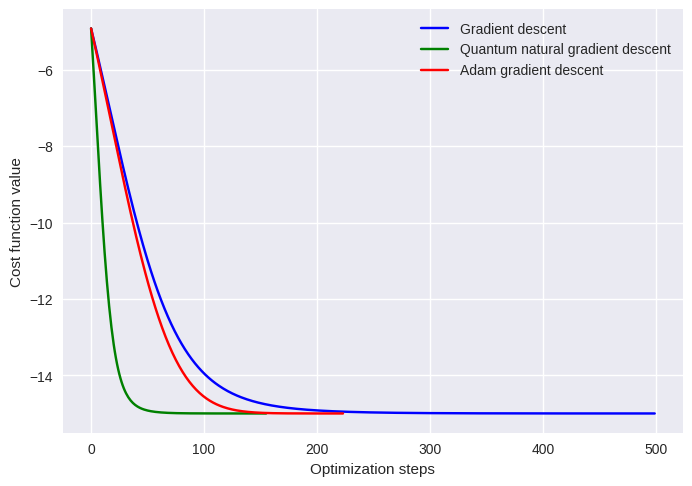

In [41]:
plt.style.use("seaborn-v0_8")
plt.plot(gd_cost_history, "b", label="Gradient descent")
plt.plot(qngd_cost_history, "g", label="Quantum natural gradient descent")
plt.plot(adam_cost_history, "r", label="Adam gradient descent")


plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()
